In [1]:
from visualitzacions import *


/Users/davidmarti/Library/CloudStorage/OneDrive-UAB/4t curs/TFG/dades/visualitzacions.py:17: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  channel_info = np.genfromtxt("channel_info.csv", delimiter=",", dtype=None)


In [2]:
from lempel_ziv_complexity import lempel_ziv_complexity
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split


### Agrupament de Canals

In [3]:

idx_canals_frontals = [channel_dict[channel] for channel in canals_frontals]
idx_canals_dreta = [channel_dict[channel] for channel in canals_dreta]
idx_canals_esquerra = [channel_dict[channel] for channel in canals_esquerra]
print("Canals frontals:", idx_canals_frontals)
print("Canals esquerra:", idx_canals_esquerra)
print("Canals dreta:", idx_canals_dreta)


Canals frontals: [0, 3, 2, 7, 8, 9, 1, 5, 6, 12, 11, 10, 4]
Canals esquerra: [20, 21, 22, 29, 28, 27, 23, 30, 15, 14, 13, 16]
Canals dreta: [26, 25, 24, 31, 32, 33, 17, 18, 19]


In [4]:
def agruparxcanals(dades):
    grup1 = dades[:, idx_canals_frontals, :].mean(axis=1)
    grup2 = dades[:, idx_canals_esquerra, :].mean(axis=1)
    grup3 = dades[:, idx_canals_dreta, :].mean(axis=1)

    total = np.stack((grup1, grup2, grup3), axis=1)
    return total, grup1, grup2, grup3

In [5]:
both_mor_red = agruparxcanals(both_mor)[0]
both_syl_red = agruparxcanals(both_syl)[0]
both_str_red = agruparxcanals(both_str)[0]
eng_mor_red = agruparxcanals(eng_mor)[0]
eng_syl_red = agruparxcanals(eng_syl)[0]
eng_str_red = agruparxcanals(eng_str)[0]
esp_mor_red = agruparxcanals(esp_mor)[0]
esp_syl_red = agruparxcanals(esp_syl)[0]
esp_str_red = agruparxcanals(esp_str)[0]

dreta_red = np.concatenate((agruparxcanals(esp_mor)[3], agruparxcanals(esp_str)[3]), axis=0)
esquerra_red = np.concatenate((agruparxcanals(eng_mor)[2], agruparxcanals(eng_str)[2]), axis=0)
frontal_red = np.concatenate((agruparxcanals(both_mor)[1],agruparxcanals(both_str)[1]), axis=0)

### Binarització de les dades


In [8]:
def binaritzar(dades):
    std = dades.mean(axis=2, keepdims=True) + dades.std(axis=2, keepdims=True)
    binarized = (dades > std).astype(int)
    return binarized

"""def binaritzar_lat(dades):
    mean = dades.mean(axis=1, keepdims=True) + dades.std(axis=1, keepdims=True)
    binarized = (dades > mean).astype(int)
    return binarized"""

'def binaritzar_lat(dades):\n    mean = dades.mean(axis=1, keepdims=True) + dades.std(axis=1, keepdims=True)\n    binarized = (dades > mean).astype(int)\n    return binarized'

In [219]:
both_mor_bin = binaritzar(both_mor_red) #modificat
both_syl_bin = binaritzar(both_syl_red) #modificat
both_str_bin = binaritzar(both_str_red)  #modificat
eng_mor_bin = binaritzar(eng_mor_red)
eng_syl_bin = binaritzar(eng_syl_red)
eng_str_bin = binaritzar(eng_str_red)
esp_mor_bin = binaritzar(esp_mor_red)
esp_syl_bin = binaritzar(esp_syl_red)
esp_str_bin = binaritzar(esp_str_red)



"""dreta_bin = binaritzar_lat(dreta_red)
esquerra_bin = binaritzar_lat(esquerra_red)
frontal_bin = binaritzar_lat(frontal_red)"""

'dreta_bin = binaritzar_lat(dreta_red)\nesquerra_bin = binaritzar_lat(esquerra_red)\nfrontal_bin = binaritzar_lat(frontal_red)'

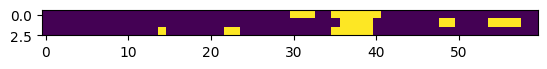

In [186]:
plt.imshow(both_mor_bin[0, :, :])


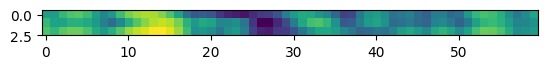

In [187]:
plt.imshow(both_mor_red[0, :, :])


### Càlcul de features

In [188]:
def proporcio_uns(dades):
    total_uns = np.sum(dades)
    total_elements = dades.size
    return total_uns / total_elements if total_elements > 0 else 0

def num_transicions(dades):
    diffs = np.diff(dades)
    trans_0_to_1 = np.sum(diffs == 1)
    return trans_0_to_1

def long_max_zeros(dades):
    max_zeros = 0
    current_zeros = 0
    for value in dades:
        if value == 0:
            current_zeros += 1
            max_zeros = max(max_zeros, current_zeros)
        else:
            current_zeros = 0
    return max_zeros

def long_max_uns(dades):
    max_uns = 0
    current_uns = 0
    for value in dades:
        if value == 1:
            current_uns += 1
            max_uns = max(max_uns, current_uns)
        else:
            current_uns = 0
    return max_uns

def moment_temporal_uns(dades):
    total = 0
    for i, value in enumerate(dades):
        total += i * value
    return total / np.sum(dades)

def complexitat_lempel_ziv(dades):
    return lempel_ziv_complexity(str(dades))

def maxminlocals(dades):
    derivada = np.zeros_like(dades)
    for i in range(0, dades.shape[0]-1):
        derivada[i] = dades[i] - dades[i - 1]
    derivada[-1] = derivada[dades.shape[0] - 2]  # Mantenir l'últim valor igual al penúltim
    # Binariar la derivada
    derivada_bin = (derivada > 0).astype(int)
    # Calcular els màxims i mínims locals
    maxminlocals = np.zeros_like(derivada_bin)
    for i in range(1, derivada_bin.shape[0] - 1):
        if derivada_bin[i] == 1 and derivada_bin[i - 1] == 0:
            maxminlocals[i] = 1
        elif derivada_bin[i] == 0 and derivada_bin[i - 1] == 1 :
            maxminlocals[i] = -1
    # conta els màxims i mínims locals
    num_max = np.sum(maxminlocals == 1)
    num_min = np.sum(maxminlocals == -1)
    return (num_max+num_min)

def mitjana(dades):
    return np.mean(dades)
def desviacio_estandard(dades):
    return np.std(dades)


In [270]:
def calcular_features(dades, dades_red):
    n = dades.shape[0]
    X_grup = np.zeros((n, 6))
    for i in range(n): 
        X_grup[i, 0] = desviacio_estandard(dades[i, 0, :])
        X_grup[i, 1] = desviacio_estandard(dades[i, 1, :])
        X_grup[i, 2] = desviacio_estandard(dades[i, 2, :])
        X_grup[i, 3] = mitjana(dades[i, 0, :])
        X_grup[i, 4] = mitjana(dades[i, 1, :])
        X_grup[i, 5] = mitjana(dades[i, 2, :])
    # Normalitzar les característiques
    return X_grup

In [271]:
X_mor = calcular_features(eng_mor_bin, eng_mor_red)
#X_syl = calcular_features(both_syl_bin, both_syl_red)
X_str = calcular_features(eng_str_bin, eng_str_red)
X = np.concatenate((X_mor, X_str), axis=0)

Y_mor = np.zeros(X_mor.shape[0])
#Y_syl = np.ones(X_syl.shape[0])
Y_str = np.ones(X_str.shape[0])
Y = np.concatenate((Y_mor, Y_str), axis=0)

### Visualització per a triar features

In [244]:
"""for i in [50, 100, 150, 200, 250]:
    plot_mean_sem_std(eng_mor[i:i+1], eng_syl[i:i+1], eng_str[i:i+1], 'none', 'eng')
"""

"""for i in [50, 100, 150, 200, 250]:
    plot_mean_sem_std(eng_mor, eng_syl, eng_str,'none', 'eng')"""


"for i in [50, 100, 150, 200, 250]:\n    plot_mean_sem_std(eng_mor, eng_syl, eng_str,'none', 'eng')"

In [245]:
mitjanes_mor = both_mor_red.mean(axis=2)
mitjanes_str = both_str_red.mean(axis=2)

num_transicions_mor = np.array([num_transicions(both_mor_bin[i, j, :]) for i in range(both_mor_bin.shape[0]) for j in range(3)]).flatten()
num_transicions_str = np.array([num_transicions(both_str_bin[i, j, :]) for i in range(both_str_bin.shape[0]) for j in range(3)]).flatten()

datalz_mor = np.transpose(both_mor_bin, (0, 2, 1)).reshape(both_mor_bin.shape[0],60*3)
datalz_str = np.transpose(both_str_bin, (0, 2, 1)).reshape(both_str_bin.shape[0],60*3)
data_englz_mor = np.transpose(eng_mor_bin, (0, 2, 1)).reshape(eng_mor_bin.shape[0],60*3)
data_englzstr = np.transpose(eng_str_bin, (0, 2, 1)).reshape(eng_str_bin.shape[0],60*3)
data_esplz_mor = np.transpose(esp_mor_bin, (0, 2, 1)).reshape(esp_mor_bin.shape[0],60*3)
data_esplz_str = np.transpose(esp_str_bin, (0, 2, 1)).reshape(esp_str_bin.shape[0],60*3)

lz_mor = np.array([complexitat_lempel_ziv(datalz_mor[i, :]) for i in range(datalz_mor.shape[0])])[:815]
lz_str = np.array([complexitat_lempel_ziv(datalz_str[i, :]) for i in range(datalz_str.shape[0])])

moment_temporal_uns_mor = np.array([moment_temporal_uns(both_mor_bin[i, j, :]) for i in range(both_mor_bin.shape[0]) for j in range(3)]).flatten()
moment_temporal_uns_str = np.array([moment_temporal_uns(both_str_bin[i, j, :]) for i in range(both_str_bin.shape[0]) for j in range(3)]).flatten()

desviacions_mor = both_mor_red.std(axis=2).flatten()
desviacions_str = both_str_red.std(axis=2).flatten()

In [246]:


"""#CALUL DE LA LZ USANT EL TEMPS
lz_mor = np.array([[complexitat_lempel_ziv(datalz_mor[i, :j+1]) for j in range (0,180,3)] for i in range(datalz_mor.shape[0])])[:815]
lz_str = np.array([[complexitat_lempel_ziv(datalz_str[i, :j+1]) for j in range(0,180,3)]for i in range(datalz_str.shape[0])])
englz_mor = np.array([[complexitat_lempel_ziv(data_englz_mor[i, :j+1]) for j in range (0,180,3)] for i in range(data_englz_mor.shape[0])])
englz_str = np.array([[complexitat_lempel_ziv(data_englzstr[i, :j+1]) for j in range(0,180,3)]for i in range(data_englzstr.shape[0])])
esplz_mor = np.array([[complexitat_lempel_ziv(data_esplz_mor[i, :j+1]) for j in range (0,180,3)] for i in range(data_esplz_mor.shape[0])])
esplz_str = np.array([[complexitat_lempel_ziv(data_esplz_str[i, :j+1]) for j in range(0,180,3)]for i in range(data_esplz_str.shape[0])])"""

"""lz_dreta = np.array([[complexitat_lempel_ziv(dreta_bin[i, :j+1]) for j in range (60)] for i in range(dreta_bin.shape[0])])[:815]
lz_esquerra = np.array([[complexitat_lempel_ziv(esquerra_bin[i, :j+1]) for j in range (60)] for i in range(esquerra_bin.shape[0])])[:815]
lz_frontal = np.array([[complexitat_lempel_ziv(frontal_bin[i, :j+1]) for j in range (60)] for i in range(frontal_bin.shape[0])])[:815]
"""


'lz_dreta = np.array([[complexitat_lempel_ziv(dreta_bin[i, :j+1]) for j in range (60)] for i in range(dreta_bin.shape[0])])[:815]\nlz_esquerra = np.array([[complexitat_lempel_ziv(esquerra_bin[i, :j+1]) for j in range (60)] for i in range(esquerra_bin.shape[0])])[:815]\nlz_frontal = np.array([[complexitat_lempel_ziv(frontal_bin[i, :j+1]) for j in range (60)] for i in range(frontal_bin.shape[0])])[:815]\n'

In [247]:
print((englz_mor.mean(axis = 0).mean(axis=0)),
(englz_str.mean(axis = 0).mean(axis=0)),
(esplz_mor.mean(axis = 0).mean(axis=0)),
(esplz_str.mean(axis = 0).mean(axis=0)))


34.6521670606777 34.494683026584866 34.65679723502304 34.74357060849598


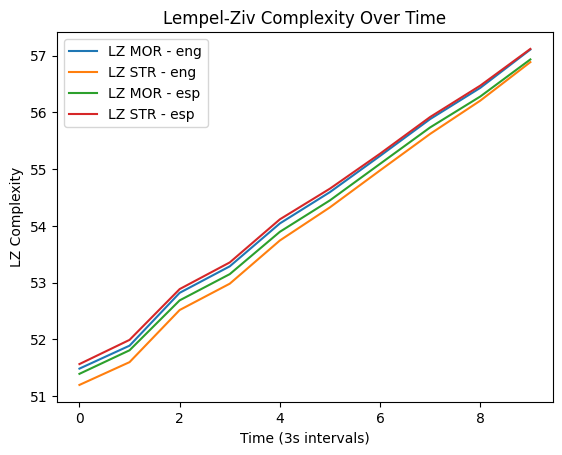

In [248]:
plt.plot(englz_mor.mean(axis = 0)[50:], label='LZ MOR - eng')
plt.plot(englz_str.mean(axis = 0)[50:], label='LZ STR - eng')
plt.plot(esplz_mor.mean(axis = 0)[50:], label='LZ MOR - esp')
plt.plot(esplz_str.mean(axis = 0)[50:], label='LZ STR - esp')

#plt.plot(lz_frontal.mean(axis = 0)[40:], label='LZ Complexity - Frontal')

plt.xlabel('Time (3s intervals)')
plt.ylabel('LZ Complexity')
plt.title('Lempel-Ziv Complexity Over Time')
plt.legend()
plt.show()

In [249]:
plt.plot(lz_mor.mean(axis = 0)[:20], label='LZ Complexity - Mor')
plt.plot(lz_str.mean(axis = 0)[:20], label='LZ Complexity - Str')

plt.xlabel('Time (3s intervals)')
plt.ylabel('LZ Complexity')
plt.title('Lempel-Ziv Complexity Over Time')
plt.legend()
plt.show()

IndexError: invalid index to scalar variable.

In [250]:
"""fig, axs = plt.subplots(4, 1, figsize=(7,18))

# Histograma num_transicions
axs[0].hist([num_transicions_mor, num_transicions_str], bins=30, label=['Transicions Mor', 'Transicions Str'], color=['blue', 'orange'], alpha=0.7)
axs[0].set_xlabel('Nombre de transicions')
axs[0].set_ylabel('Freqüència')
axs[0].set_title('Histograma de transicions')
axs[0].legend()

# Histograma moment_temporal_uns
long_max_zeros_mor = [moment_temporal_uns(both_mor_bin[i, j, :]) for i in range(both_mor_bin.shape[0]) for j in range(3)]
long_max_zeros_str = [moment_temporal_uns(both_str_bin[i, j, :]) for i in range(both_str_bin.shape[0]) for j in range(3)]
axs[1].hist([long_max_zeros_mor, long_max_zeros_str], bins=30, label=['Moment temporal d\'uns Mor', 'Moment temporal d\'uns Str'], color=['blue', 'orange'], alpha=0.7)
axs[1].set_xlabel('Moment temporal d\'uns')
axs[1].set_ylabel('Freqüència')
axs[1].set_title('Histograma de moment temporal d\'uns')
axs[1].legend()

# Histograma long_max_uns
long_max_uns_mor = [long_max_uns(both_mor_bin[i, j, :]) for i in range(both_mor_bin.shape[0]) for j in range(3)]
long_max_uns_str = [long_max_uns(both_str_bin[i, j, :]) for i in range(both_str_bin.shape[0]) for j in range(3)]
axs[2].hist([long_max_uns_mor, long_max_uns_str], bins=30, label=["Longitud màxima d'uns Mor", "Longitud màxima d'uns Str"], color=['blue', 'orange'], alpha=0.7)
axs[2].set_xlabel("Longitud màxima d'uns")
axs[2].set_ylabel('Freqüència')
axs[2].set_title("Histograma de longitud màxima d'uns")
axs[2].legend()

# Histograma màxims locals
maxims_mor = np.array([maxminlocals(both_mor_bin[i, j, :]) for i in range(both_mor_bin.shape[0]) for j in range(3)]).flatten()
maxims_str = np.array([maxminlocals(both_str_bin[i, j, :]) for i in range(both_str_bin.shape[0]) for j in range(3)]).flatten()
axs[3].hist([maxims_mor, maxims_str], bins=30, label=['Màxims locals Mor', 'Màxims locals Str'], color=['blue', 'orange'], alpha=0.7)
axs[3].set_xlabel('Nombre de màxims locals')
axs[3].set_ylabel('Freqüència')
axs[3].set_title('Histograma de màxims locals')
axs[3].legend()

plt.tight_layout()
plt.show()
"""



'fig, axs = plt.subplots(4, 1, figsize=(7,18))\n\n# Histograma num_transicions\naxs[0].hist([num_transicions_mor, num_transicions_str], bins=30, label=[\'Transicions Mor\', \'Transicions Str\'], color=[\'blue\', \'orange\'], alpha=0.7)\naxs[0].set_xlabel(\'Nombre de transicions\')\naxs[0].set_ylabel(\'Freqüència\')\naxs[0].set_title(\'Histograma de transicions\')\naxs[0].legend()\n\n# Histograma moment_temporal_uns\nlong_max_zeros_mor = [moment_temporal_uns(both_mor_bin[i, j, :]) for i in range(both_mor_bin.shape[0]) for j in range(3)]\nlong_max_zeros_str = [moment_temporal_uns(both_str_bin[i, j, :]) for i in range(both_str_bin.shape[0]) for j in range(3)]\naxs[1].hist([long_max_zeros_mor, long_max_zeros_str], bins=30, label=[\'Moment temporal d\'uns Mor\', \'Moment temporal d\'uns Str\'], color=[\'blue\', \'orange\'], alpha=0.7)\naxs[1].set_xlabel(\'Moment temporal d\'uns\')\naxs[1].set_ylabel(\'Freqüència\')\naxs[1].set_title(\'Histograma de moment temporal d\'uns\')\naxs[1].legend()

In [251]:
"""# plotting the mean of the power during time in the three groups
both_mor_mean = eng_mor_red.mean(axis=1)[:,1]
both_str_mean = eng_str_red.mean(axis=1)[:,1]
plt.hist(both_mor_mean, bins=30, alpha=0.7, label='Mor')
plt.hist(both_str_mean, bins=30, alpha=0.7, label='Str')

plt.xlabel('Mean Power')
plt.ylabel('Frequency')
plt.title('Distribució de la Potència Mitjana en els Grups Mor i Str')
plt.legend()
plt.show()

#same for std
both_mor_std = eng_mor_red.std(axis=2).mean(axis=1)
both_str_std = eng_str_red.std(axis=2).mean(axis=1)
plt.hist(both_mor_std, bins=30, alpha=0.7, label='Mor')
plt.hist(both_str_std, bins=30, alpha=0.7, label='Str')
plt.xlabel('Standard Deviation of Power')
plt.ylabel('Frequency')
plt.title('Distribució de la Desviació Estàndard de la Potència en els Grups Mor i Str (ESP)')
plt.legend()
plt.show()"""

"# plotting the mean of the power during time in the three groups\nboth_mor_mean = eng_mor_red.mean(axis=1)[:,1]\nboth_str_mean = eng_str_red.mean(axis=1)[:,1]\nplt.hist(both_mor_mean, bins=30, alpha=0.7, label='Mor')\nplt.hist(both_str_mean, bins=30, alpha=0.7, label='Str')\n\nplt.xlabel('Mean Power')\nplt.ylabel('Frequency')\nplt.title('Distribució de la Potència Mitjana en els Grups Mor i Str')\nplt.legend()\nplt.show()\n\n#same for std\nboth_mor_std = eng_mor_red.std(axis=2).mean(axis=1)\nboth_str_std = eng_str_red.std(axis=2).mean(axis=1)\nplt.hist(both_mor_std, bins=30, alpha=0.7, label='Mor')\nplt.hist(both_str_std, bins=30, alpha=0.7, label='Str')\nplt.xlabel('Standard Deviation of Power')\nplt.ylabel('Frequency')\nplt.title('Distribució de la Desviació Estàndard de la Potència en els Grups Mor i Str (ESP)')\nplt.legend()\nplt.show()"

In [252]:
print(both_mor_red.shape, both_str_red.shape)


(1714, 3, 60) (1686, 3, 60)


### Training


In [275]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [276]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

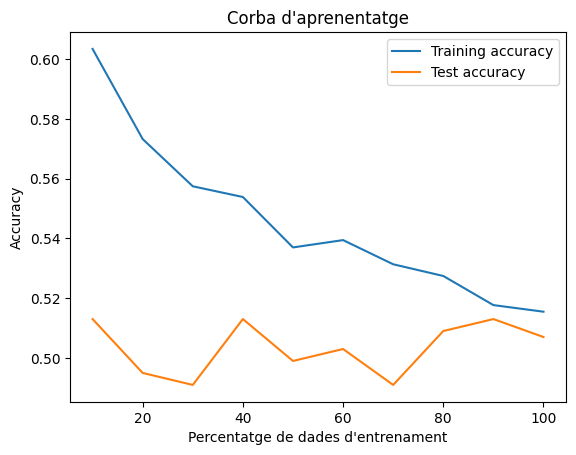

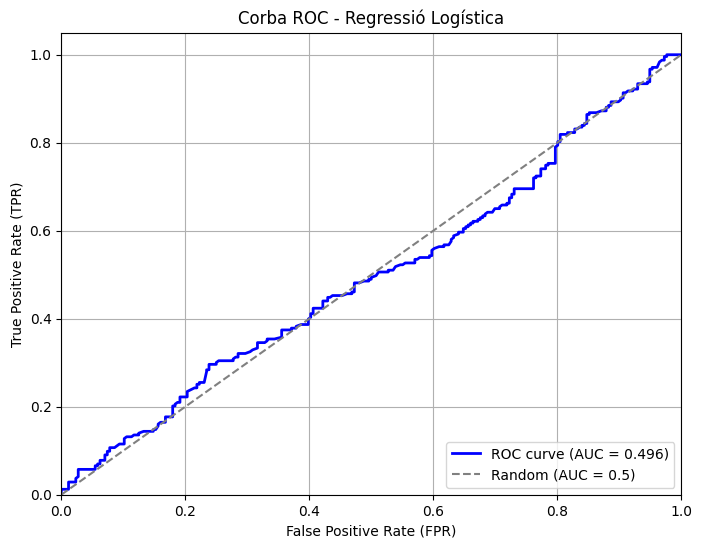

Accuracy mitjana amb validació creuada: 0.50 ± 0.01
Accuracy del model (test): 0.51
Matriu de confusió:
[[153 103]
 [143 100]]


In [277]:
from sklearn.model_selection import cross_val_score

train_sizes = np.linspace(0.1, 1.0, 10)  # de 10% a 100% de les dades d'entrenament
train_accuracies = []
val_accuracies = []

for train_size in train_sizes:
    # Escollim una porció de les dades d'entrenament
    n_train_samples = int(train_size * len(X_train))
    X_train_B = X_train[:n_train_samples]
    y_train_B = y_train[:n_train_samples]
    
    model = LogisticRegression()
    model.fit(X_train_B, y_train_B)
    
    y_train_pred = model.predict(X_train_B)
    y_test_pred = model.predict(X_test)
    
    train_accuracies.append(accuracy_score(y_train_B, y_train_pred))
    val_accuracies.append(accuracy_score(y_test, y_test_pred))

plt.plot(train_sizes * 100, train_accuracies, label='Training accuracy')
plt.plot(train_sizes * 100, val_accuracies, label='Test accuracy')
plt.xlabel('Percentatge de dades d\'entrenament')
plt.ylabel('Accuracy')
plt.title('Corba d\'aprenentatge')
plt.legend()
plt.show()

# 5. Obtenim les probabilitats de predicció (classe positiva)
y_probs = model.predict_proba(X_test)[:, 1]

# 6. Calculem la corba ROC i l'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# 7. Visualització de la corba ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Corba ROC - Regressió Logística')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Avaluació del model amb validació creuada
model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
print(f'Accuracy mitjana amb validació creuada: {scores.mean():.2f} ± {scores.std():.2f}')


# Avaluació del model sobre el test set
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy del model (test): {accuracy:.2f}')
# Matriu de confusió
confusion = confusion_matrix(y_test, y_test_pred)
print('Matriu de confusió:')
print(confusion)


